# Data Generation

Here's a breakdown of the data generation process:
- First, with the function `poly(x)` we simulate the connection between output `y` and input `x`.
- `x`  is generated as tensor containing equally spaced values between start- and end-value. It is achieved using `torch.linspace`, which creates a one-dimensional tensor of equally spaced points within a `step = data_size`.
- `y` is generated by applying `poly(x)` to each value of `x`
-  To introduce randomness to data we use Gaussian noise with standard deviation, which is achieved through `torch.randn_like`.The resulting noisy data points are stored in `noisy_x` and `noisy_y`. 


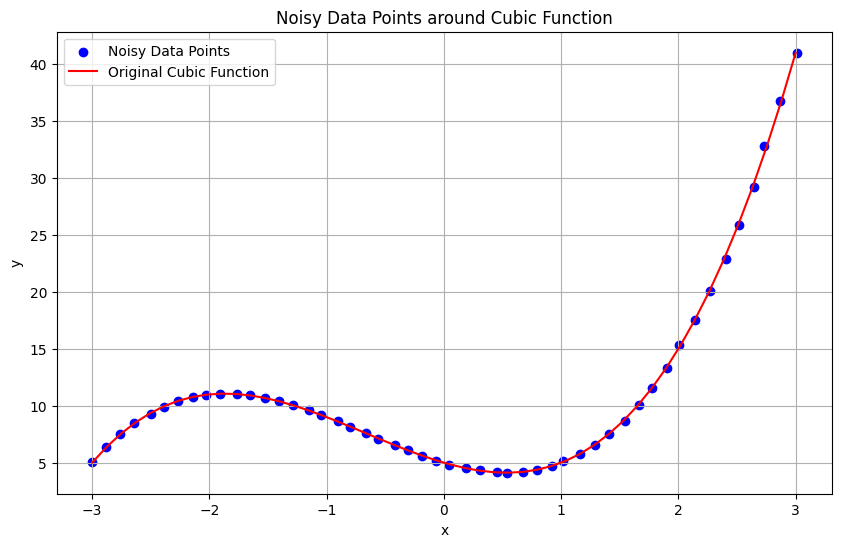

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import math
import numpy as np
import matplotlib.pyplot as plt
import optuna
import torch.utils.tensorboard as tb

p4 = 0
p3 = 1
p2 = 2
p1 = -3
p0 = 5

def poly(x):
    return p4*x**4 + p3*x**3 + p2*x**2 + p1*x + p0


def data_generator(data_size=20, noise_std=0.1):
    x = torch.linspace(-3, 3, steps=data_size)
    y = poly(x)

    noisy_x = x + torch.randn_like(x) * noise_std
    noisy_y = y + torch.randn_like(y) * noise_std


    return noisy_x, noisy_y, x, y

noisy_x, noisy_cubic_y, x_normal, y_normal = data_generator(data_size=50, noise_std=0.01)

plt.figure(figsize=(10, 6))
plt.scatter(noisy_x.numpy(), noisy_cubic_y.numpy(), label='Noisy Data Points', color='blue')
plt.plot(x_normal.numpy(), y_normal.numpy(), label='Original Cubic Function', color='red')
plt.title('Noisy Data Points around Cubic Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Linear Regression Model


### Model Architecture (Static model) 
This model is statically created with three hidden layers followed by an output layer. Each hidden layer is fully connected with a specified number of nodes.

- **Input Layer:** The input layer has one node, representing the input feature (x).
- **Hidden Layers:** There are three hidden layers, each transforming the input through linear transformations followed by rectified linear unit (ReLU) activation functions.
- **Output Layer:** The output layer is a single node (y) as the result of the task.


In [3]:
class LinearRegression3Layer(nn.Module):
    def __init__(self):
        super(LinearRegression3Layer, self).__init__()
        self.hidden1 = nn.Linear(1, 5)
        self.hidden2 = nn.Linear(5, 5)
        self.hidden3 = nn.Linear(5, 5)
        self.output = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = self.output(x)
        return x

### Model Architecture (Dynamic Version with Variable Numbers of Layers)

The dynamic version of the linear regression model introduces flexibility in the number of hidden layers, allowing it to adapt to different complexities of the data or tasks.

- **Input Layer:** Similar to the static model, the input layer has one node representing the input feature (x).
- **Hidden Layers:** The number of hidden layers is determined by the `num_layers` parameter passed during initialization. Each hidden layer performs a linear transformation followed by ReLU activation, similar to the static model. However, the dynamic aspect here is that the number of hidden layers can vary.
- **Output Layer:** The output layer remains the same, producing a single node (y) as the result of the task.


In [4]:
class DynamicLinearRegression0(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.input = nn.Linear(1, 5) 
        self.hidden_layers = nn.ModuleList([nn.Linear(5, 5) for _ in range(num_layers - 1)])
        self.output = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.input(x))  # Pass through the input layer
        for i, layer in enumerate(self.hidden_layers):
            x = self.hidden_layers[i // 2](x) + layer(x)
        x = self.output(x)
        return x

### Model Architecture (Dynamic Version with Variable Layer Nodes)

The dynamic linear regression model with variable layer nodes enhances the adaptability of the model by allowing customization of the number of nodes in each hidden layer.

- **Input Layer:** The input layer remains consistent, with one node representing the input feature (x).

- **Hidden Layers:** The number of hidden layers is determined by the `num_layers` parameter passed during initialization. Each hidden layer consists of a linear transformation followed by ReLU activation, but the number of nodes in each layer varies based on the `layer_nodes` parameter. This flexibility enables the model to adjust its complexity according to the dataset or task requirements.

- **Output Layer:** Similar to both static and dynamic versions, the output layer produces a single node (y) as the result of the regression task.


In [5]:
class DynamicLinearRegression1(nn.Module):
    def __init__(self, num_layers, layer_nodes):
        super().__init__()
        self.num_layers = num_layers
        self.input = nn.Linear(1, layer_nodes[0]) 
        self.hidden_layers = nn.ModuleList([nn.Linear(layer_nodes[i], layer_nodes[i+1]) for i in range(num_layers - 1)])
        self.output = nn.Linear(layer_nodes[-1], 1)

    def forward(self, x):
        x = torch.relu(self.input(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output(x)
        return x

## Cross-Validation using KFold

In K-Fold cross-validation, the dataset is divided into K subsets, or folds, and the model is trained and evaluated K times, each time using a different fold as the test set and the remaining folds as the training set.

In this code below, 50 datapoints is splitted with K-Fold cross-validation using the `KFold` class from the `sklearn.model_selection` in Python.


In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

kf.split(noisy_x)

for i, (train_index, val_index) in enumerate(kf.split(noisy_x)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={val_index}")
    print(f"Train input points= {noisy_x[train_index]}")
    print(f"Test input points= {noisy_x[val_index]}")

Fold 0:
  Train: index=[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
  Test:  index=[0 1 2 3 4 5 6 7 8 9]
Train input points= tensor([-1.7654, -1.6521, -1.5282, -1.4049, -1.2858, -1.1517, -1.0472, -0.9048,
        -0.7969, -0.6680, -0.5586, -0.4181, -0.3063, -0.1847, -0.0635,  0.0473,
         0.1903,  0.3076,  0.4544,  0.5424,  0.6704,  0.7966,  0.9199,  1.0119,
         1.1595,  1.2872,  1.4105,  1.5431,  1.6632,  1.7753,  1.9036,  2.0092,
         2.1411,  2.2671,  2.4047,  2.5148,  2.6426,  2.7310,  2.8687,  3.0085])
Test input points= tensor([-2.9976, -2.8852, -2.7629, -2.6421, -2.4956, -2.3908, -2.2699, -2.1359,
        -2.0280, -1.9099])
Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
  Test:  index=[10 11 12 13 14 15 16 17 18 19]
Train input points= tensor([-2.9976, -2.8852, -2.7629, -2.6421, -2.4956, -2.3

# Optuna: Hyperparameter Optimization Framework

Optuna is a hyperparameter optimization framework that automates the process of tuning hyperparameters to improve the performance of machine learning models.

## Key Concepts

### 1. Objective Function
The objective function is the function that you want to optimize. Here the `objective` function takes a set of hyperparameters as input (e.g., learning rate, number of epochs), trains a model using these hyperparameters, and returns the validation loss.

### 2. Search Space
The search space defines the range or distribution of possible values for each hyperparameter. For example, `trial.suggest_float` and `trial.suggest_int` are used to define the search space for the learning rate and number of epochs, respectively.

### 3. Study
A study manages the optimization process. It tracks the trials (individual evaluations of the objective function with different hyperparameters) and keeps track of the best set of hyperparameters found so far. In the example, `optuna.create_study` is used to create a study, and `study.optimize` initiates the optimization process by repeatedly calling the objective function with different hyperparameters.

### 4. Trial
A trial represents a single execution of the function with a specific set of hyperparameters. Optuna automatically samples hyperparameters from the search space and passes them to the objective function during each trial. The objective function evaluates the model's performance with the given hyperparameters, and the trial records the result. 


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


# Define the objective function
def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    num_epochs = trial.suggest_int('num_epochs', 100, 1000)
    num_layers = trial.suggest_int('num_layers', 1, 5)
    layer_nodes = [trial.suggest_int(f'layer_{i}_nodes', 1, 10) for i in range(num_layers)]
    
    kf = KFold(n_splits=5, shuffle=True)
    
    total_loss = 0.0
    for train_index, val_index in kf.split(noisy_x):
        train_x, train_y = noisy_x[train_index], noisy_cubic_y[train_index]
        val_x, val_y = noisy_x[val_index], noisy_cubic_y[val_index]

        model = DynamicLinearRegression1(num_layers, layer_nodes)
        loss_fnc = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for _ in range(num_epochs):
            outputs = model(train_x.unsqueeze(1))
            loss = loss_fnc(outputs, train_y.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            val_outputs = model(val_x.unsqueeze(1))
            val_loss = loss_fnc(val_outputs, val_y.unsqueeze(1))
        
        total_loss += val_loss.item()

    return total_loss / 5 

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Optuna: Evaluation Methods

Optuna provides several evaluation methods and techniques to assess the performance of hyperparameter optimization experiments and gain insights into the optimization process. These evaluation methods help users understand the behavior of the optimization algorithm, analyze trial results, and make informed decisions about model hyperparameters.

## Key Evaluation Methods

### 1. Study Statistics
- **Best Trial**: Optuna keeps track of the best trial found during the optimization process. Users can access information about the best trial, including its hyperparameters through `study.best_params` and evaluation metric (e.g., validation loss, accuracy) through `study.best_value`.

### 2. Trial History Visualization
- **Visualization Tools and Plotting Functions**: Optuna offers visualization tools to plot various aspects of the optimization process, including 
    - Optimization history of all trials in a study with `optuna.visualization.plot_optimization_history`.
    - Parameter relationship as slice plot in a study with `optuna.visualization.plot_slice`.
    - Hyperparameter importances distribution in percentage. `optuna.visualization.plot_param_importances`
    - And many more [link](https://optuna.readthedocs.io/en/stable/reference/visualization/index.html#).




In [87]:
print(study.best_params) 
study.best_value

{'lr': 0.020035616031717843, 'num_epochs': 737, 'num_layers': 5, 'layer_0_nodes': 4, 'layer_1_nodes': 10, 'layer_2_nodes': 9, 'layer_3_nodes': 10, 'layer_4_nodes': 8}


0.14627126716077327

In [88]:
optuna.visualization.plot_optimization_history(study)

In [89]:
optuna.visualization.plot_slice(study, params=['lr','num_epochs','num_layers', 'layer_0_nodes','layer_1_nodes','layer_2_nodes','layer_3_nodes','layer_4_nodes'])

In [90]:
optuna.visualization.plot_param_importances(study)

# Experiment Tracking Tool : TensorBoard

TensorBoard is a visualization toolkit that comes with TensorFlow, a popular open-source machine learning framework developed by Google. It also supports Pytorch with fewer Functionalities.  

## Key Features

### 1. Visualization of ML Model

TensorBoard allows you to visualize the model as a graph. It provides insights into how data flows through your model, making it easier to understand its architecture.

### 2. Monitoring Training Metrics

You can use TensorBoard to monitor training metrics such as loss, accuracy, ect.. . These metrics are plotted as interactive charts, allowing you to track the progress of your models training process.

### 3. Visualization of Model Histograms and Distributions

TensorBoard also enables you to visualize the histograms and distributions of your model's weights, biases, and other parameters.

### 4. Other Functions

- TensorBoard supports embedding visualizations, which allow you to project high-dimensional data into a lower-dimensional space for visualization.
- TensorBoard includes profiling tools that allow you to analyze the performance of your model and identify performance bottlenecks.

## Usage

To use TensorBoard, you first need to log the relevant data and visualizations during the training process using TensorFlow's SummaryWriter API. Once you have logged the data, you can launch TensorBoard from the command line and view the visualizations in your web browser.


In [ ]:
#runs Tensorboard session
%load_ext tensorboard

%tensorboard --logdir runs

In [91]:
# Get the best hyperparameters
best_lr = study.best_params['lr']
best_epochs = study.best_params['num_epochs']
best_num_layers = study.best_params['num_layers']
best_layer_nodes = [study.best_params[f'layer_{i}_nodes'] for i in range(best_num_layers)]
print("Best learning rate:", best_lr)
print("Best number of epochs:", best_epochs)
print("Best number of layers:", best_num_layers)
print("Best number of nodes in each layer:", best_layer_nodes)

writer = tb.SummaryWriter()
writer.add_graph(best_model, noisy_x.unsqueeze(1))
writer.close()

Best learning rate: 0.020035616031717843
Best number of epochs: 737
Best number of layers: 5
Best number of nodes in each layer: [4, 10, 9, 10, 8]


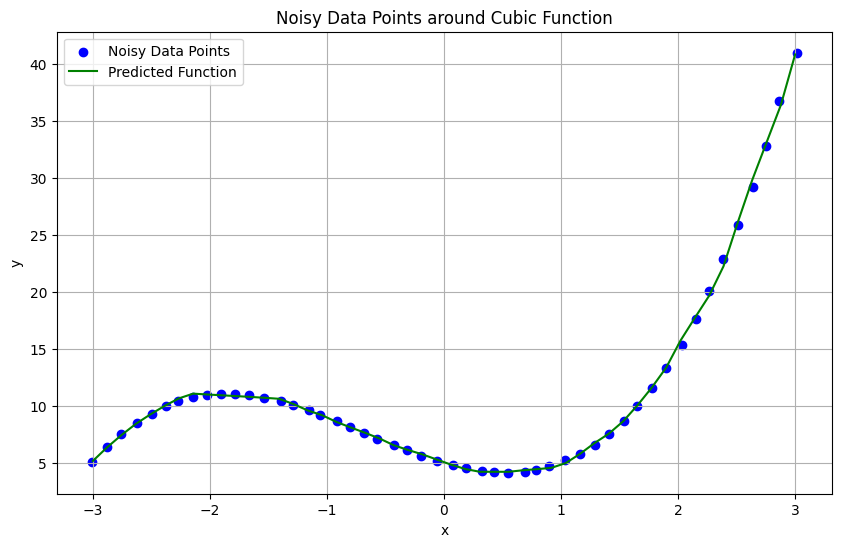

In [92]:
import torch.utils.tensorboard as tb

writer = tb.SummaryWriter()

best_model = DynamicLinearRegression1(best_num_layers, best_layer_nodes)
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)
loss_fnc = nn.MSELoss()

for epoch in range(best_epochs):
    outputs = best_model(noisy_x.unsqueeze(1))
    loss = loss_fnc(outputs, noisy_cubic_y.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:  # Adjust the frequency of logging histograms as needed
        for name, param in best_model.named_parameters():
            writer.add_histogram(name, param, epoch)

    if (epoch % 100 == 0) or (epoch == best_epochs - 1):
        with torch.no_grad():
            predicted_y = best_model(noisy_x.unsqueeze(1)).numpy()
            writer.add_scalar('Loss/train', loss.item(), epoch)
            writer.add_embedding(predicted_y, metadata=None, global_step=epoch)

            # Plot the predicted y line
            plt.figure(figsize=(10, 6))
            plt.scatter(noisy_x.numpy(), noisy_cubic_y.numpy(), label='Noisy Data Points', color='blue')
            plt.plot(noisy_x.numpy(), predicted_y, label='Predicted Function', color='green')
            plt.title('Noisy Data Points around Cubic Function')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend()
            plt.grid(True)
            plt.savefig(f'epoch_{epoch}.png')  # Save the plot as an image
            plt.close()

            # Log the plot as an image to TensorBoard
            image_path = f'epoch_{epoch}.png'
            image = plt.imread(image_path)
            writer.add_image('Predicted_Function', torch.tensor(np.moveaxis(image, -1, 0)), global_step=epoch)


writer.close()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(noisy_x.numpy(), noisy_cubic_y.numpy(), label='Noisy Data Points', color='blue')

with torch.no_grad():
    predicted_y = best_model(noisy_x.unsqueeze(1)).numpy()
    plt.plot(x_normal.numpy(), predicted_y, label='Predicted Function', color='green')

plt.title('Noisy Data Points around Cubic Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()